In [1]:
import healpy as hp
import pylab as mplot
%pylab inline
import astropy.io.fits as pf
import astropy.io.fits as fits
import numpy as np
import scipy 
import kmeans_radec

Populating the interactive namespace from numpy and matplotlib


## Redmapper Mask

In [25]:
from astropy.io import fits
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


# Read in Redmapper data
hdul = fits.open('/Users/arielamsellem/Desktop/Research/splashback_codes/RM_cluster_rand.fits')
data = hdul[1].data
cols = hdul[1].columns
print(cols.names)

# Coordinates of redmapper galaxies
ra = data.field('RA')
dec = data.field('DEC')
print(ra[0:10])
print(dec[0:10])

ra_rad = ra * np.pi * (1./180.)
dec_rad = dec * np.pi * (1./180.)

theta = np.pi/2 - dec_rad
print(np.max(ra_rad))
print(np.min(ra_rad))
print()

['RA', 'DEC', 'Z', 'LAMBDA', 'W', 'JK']
[ 4.3466754  4.1713424  4.9303865 10.514455   9.168657   9.674061
  4.707538   7.046179  17.902739  18.188862 ]
[-40.78864  -41.591328 -41.2684   -42.13053  -41.16781  -41.48712
 -43.08256  -42.93594  -40.55957  -40.704903]
6.283184
5.3709283e-07
2200708
2200708


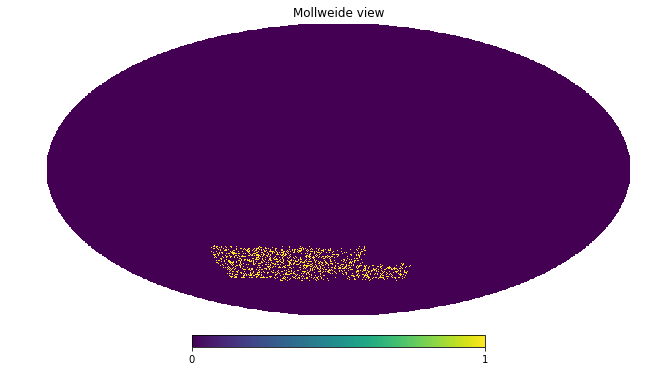

In [29]:
pix = hp.ang2pix(4096, theta, ra_rad)
mask_rm = np.zeros(hp.nside2npix(4096))
mask_rm[pix] = 1
hp.mollview(mask_rm)


## WaZP Mask

In [34]:
# Read in the Unpublished data
hdu2 = fits.open('/Users/arielamsellem/Desktop/Research/Initial_codes/wazp_cluster_newz.fits')
data_u = hdu2[1].data
cols_u = hdu2[1].columns
print(cols_u.names)

# Coordinates of Unpublished data
ra_u = data_u.field('ra')
dec_u = data_u.field('dec')
z_u = data_u.field('zp_new')
ngal_u = data_u.field('ngals')

mask = pf.open('./vac_3960.4902_joined_corr_footprint_map.fits')
cols_mask = mask[1].columns
#print(cols_mask_w.names)
#print(mask_w[1].data['pixel'])
# figuring out what's the maximum number in the index, in order to figure out the nside
#mplot.plot(mask_w[1].data)
# try nside=4096
#hp.nside2npix(4096)
# now populate the mask, define a zero array with the length of a nside 4096 map
mask_w = np.zeros(hp.nside2npix(4096))


# set the footprint pixel ids to 1
mask_w[mask[1].data['pixel']] = 1

['SeqNr', 'DETECTION_TILE', 'IZ_INIT', 'IZ_FINAL', 'PEAK_ID_TILE_IZ', 'ID_IN_TILE', 'RA', 'DEC', 'zp', 'zp_median', 'Z_INIT', 'ZMIN_CL', 'ZMAX_CL', 'ZMIN_95_CL', 'ZMAX_95_CL', 'MSTAR_CL', 'XPEAK', 'YPEAK', 'RADIUS_ISO_MPC', 'RADIUS_SADDLE_MPC', 'MAXWAVE', 'FLUX_WAVE', 'FLAG_MERGE', 'SIGMA_DZ_INIT', 'SIGMA_DZ_EFF', 'FLAG_ZP', 'NGAL_FOR_ZP', 'FLAG_IZ', 'GLOBAL_NBKG_ZM', 'GLOBAL_LBKG_ZM', 'SIG_NBKG_ZM', 'SIG_LBKG_ZM', 'LOCAL_NBKG_ZM', 'LOCAL_LBKG_ZM', 'AREA_LOCAL_BKG', 'MASKED_FRAC_1MPC', 'MASKED_FRAC_05MPC', 'MASKED_FRAC_03MPC', 'SNR', 'SNR_NGALS', 'SNR_LGALS', 'CONTRAST_NGALS', 'CONTRAST_LGALS', 'DMAG_CORE', 'DMAG_BCG', 'DIST_BCG', 'NGALS_TEST', 'NGALS_CEN', 'LGALS_CEN', 'LOCAL_NBKG', 'LOCAL_LBKG', 'GLOBAL_NBKG', 'GLOBAL_LBKG', 'SIG_NBKG', 'SIG_LBKG', 'OUT_OF_CYL', 'CYL_NSL', 'PARENT_CYL_NSL', 'ZMIN_CYL', 'ZMAX_CYL', 'IZ_MIN_CYL', 'IZ_MAX_CYL', 'CONTRAST_CYL', 'NMAX_CYL', 'KING_Rc', 'KING_D0', 'KING_CHI2', 'KING_NFIT', 'RADIUS_MPC', 'RADIUS_AMIN', 'RADIUS_MAX_CONTRAST', 'RADIUS_SCALING'

193537048
7789544
199478892
5941844


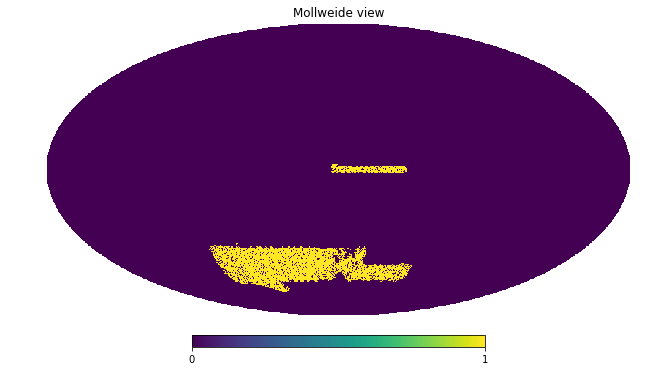

In [37]:
# show the mask
hp.mollview(mask_w)

# WaZP Information
print(len(mask_w) - len(np.where(mask_w == 1)[0]))
print(len(np.where(mask_w == 1)[0]))

# RM Information
print(len(mask_rm) - len(np.where(mask_rm == 1)[0]))
print(len(np.where(mask_rm == 1)[0]))

In [69]:
def radec2thetaphi(ra, dec, nside):
    """
    Convert RA DEC in degrees to THETA and PHI in Healpix 
    convention. 
    """

    theta = (90.0 - dec)*np.pi/180.0
    phi = ra*np.pi/180.0
    return theta, phi

def make_mask(ra, dec, nmin=1, nside=4096):
    """
    Take RA, DEC, build a binary mask just by assigning 
    1 to pixels with count>=nmin and 0 otherwise. Mask 
    is in Healpix format with assigned nside. 
    """
    mask = np.zeros(hp.nside2npix(nside))
    theta, phi = radec2thetaphi(ra, dec, nside)
    pix = hp.ang2pix(nside, theta, phi, nest=False)
    for i in range(len(pix)):
        mask[pix[i]] += 1
    mask[mask>=nmin] = 1
    mask[mask!=1] = 0

    return mask

def make_random(mask, ramin, ramax, decmin, decmax, N=1000, nside=4096, seed=100):
    """
    Create N random points within a given mask.
    """

    #print('Building the random catalog...')

    np.random.seed(seed)
    ra_rand = (np.random.random(N)* (ramax - ramin))+ramin
    v = np.random.random(N)
    #print len(v)
    vmin = np.cos((90.0+decmin)/180.*np.pi)
    vmax = np.cos((90.0+decmax)/180.*np.pi)
    v *= (vmax-vmin)
    v += vmin
    #v *= 2
    #v -= 1
    dec_rand = np.arccos(v)
    np.rad2deg(dec_rand,dec_rand)
    dec_rand -= 90.0
    #dec_rand_se =((dec_rand < decmax)&(dec_rand > decmin))
    #ra_rand, dec_rand = ra_rand[dec_rand_se],dec_rand[dec_rand_se]
    #print len(ra_rand)
    #print 'Masking the random catalog...'

    #Converting degrees into radians
    theta_rand = (90.0 - dec_rand)*np.pi/180.
    phi_rand = ra_rand*np.pi/180.
    pix_rand = hp.ang2pix(nside, theta_rand, phi_rand, nest=False)

    #goodm, = np.where(mask[pix_rand]==1)
    #ra_rand = ra_rand[goodm]
    #dec_rand = dec_rand[goodm]
    #print len(ra_rand)

    return ra_rand, dec_rand

In [70]:
ra_rand, dec_rand = make_random(pix_w, 0.004271, 359.990874, -67.379043, -38.201655)
w,z, Lambda, jkid = np.ones(1000),np.ones(1000),np.ones(1000),np.ones(1000)
obj = np.column_stack((ra_rand, dec_rand))
print(len(jkid))

1000


In [71]:
col1 = fits.Column(name='RA', format='E', array=ra_rand)
col2 = fits.Column(name='DEC', format= 'E', array=dec_rand)
col3 = fits.Column(name='Z', format='E', array=z)
col4 = fits.Column(name='LAMBDA', format='E', array = Lambda)
col5 = fits.Column(name='W', format='E', array=w)
col6 = fits.Column(name='JK', format='E', array=jkid)

cols_ran = fits.ColDefs([col1, col2, col3, col4, col5, col6])
hdu_ran = fits.BinTableHDU.from_columns(cols_ran)
#hdu_ran.writeto('./WaZP_cluster_rand.fits')

In [72]:
ra = fits.Column(name='RA', format='E', array=ra_u)
dec = fits.Column(name='DEC', format= 'E', array=dec_u)
z = fits.Column(name='Z', format='E', array=z_u)
ngal = fits.Column(name='LAMBDA', format='E', array = ngal_u)
jk = fits.Column(name='JK', format='E', array=jkid)

cols = fits.ColDefs([ra, dec, z, ngal, jk])
hdu = fits.BinTableHDU.from_columns(cols)
#hdu.writeto('./WaZP_cluster.fits')
W = pf.open('./WaZP_cluster.fits')[1].data
cols = pf.open('./WaZP_cluster.fits')[1].columns
print(cols)
        
arr_z = np.where((W['Z']>=0.2) & (W['Z']<=0.55))
arr_l = np.where((W['lambda']>=20.) & (W['lambda']<=110.))

print(len(arr_z[0]))
print(len(arr_l[0]))
print(arr_z[0][0:150])
print(arr_l[0][0:150])

num = []
for valz in arr_z[0]:
    for vall in arr_l[0]:
        if valz == vall:
            num.append(valz)
            
#print(num)

ColDefs(
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'Z'; format = 'E'
    name = 'LAMBDA'; format = 'E'
    name = 'JK'; format = 'E'
)
30323
13360
[  3   4   5   7   8  18  22  23  24  25  28  30  31  34  35  36  37  46
  52  53  56  61  63  65  66  67  69  70  72  75  80  82  83  84  86  87
  92  93  94  95  99 101 104 107 108 112 116 117 118 119 123 124 126 128
 131 133 139 140 143 145 150 151 152 153 154 155 159 160 162 164 165 167
 168 169 170 172 173 174 176 178 179 180 184 189 190 191 192 193 194 197
 198 200 201 202 206 207 208 209 210 211 212 215 216 219 223 228 236 240
 242 243 245 248 251 256 257 258 261 265 266 267 269 270 271 275 276 278
 279 280 281 283 286 288 289 290 291 292 294 295 297 298 299 300 303 304
 305 307 310 313 314 315]
[   6   30   41   44   53   86   93   98  104  147  148  157  219  246
  284  289  299  300  324  331  346  356  368  387  399  412  420  426
  433  435  442  469  532  537  538  557  603  604  613  626  634  650


KeyboardInterrupt: 

In [ ]:
print(len(num))

def anydup(thelist):
  seen = set()
  for x in thelist:
    if x in seen: return True
    seen.add(x)
  return False

anydup(num)

In [ ]:
%matplotlib notebook

n0 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_0.npz')
n1 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_1.npz')
n2 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_2.npz')
n3 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_3.npz')
n4 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_4.npz')
n5 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_5.npz')
n6 = np.load('./Sigmag_WaZP_results/Sigmag_WaZP_6.npz')

fig, ax = plt.subplots()
plt.plot(n0['R'],n0['xi'], color = 'red', label = 'mean z = .225')
plt.plot(n1['R'],n1['xi'], color = 'orange', label = 'mean z = .275')
plt.plot(n2['R'],n2['xi'], color = 'yellow', label = 'mean z = .325')
plt.plot(n3['R'],n3['xi'], color = 'green', label = 'mean z = .375')
plt.plot(n4['R'],n4['xi'], color = 'blue', label = 'mean z = .425')
plt.plot(n5['R'],n5['xi'], color = 'purple', label = 'mean z = .475')
plt.plot(n6['R'],n6['xi'], color = 'k', label = 'mean z = .525')
plt.xlabel('log(R)', fontsize = 14, labelpad = -6.)
plt.ylabel('log(xi)', fontsize = 14, labelpad = 0)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize = 11)

plt.savefig('./Sigmag_WaZP_results/Sigmag_WaZP_results.png', dpi = 600)
plt.show()

In [ ]:
print(n0['ave_dens'])